# **RAG** 기반 작업의 비용 효율성을 높이기 위한 프롬프팅: 토큰 수 감소를 위한 검색 문맥 압축 적용

저자:  
 - [Lior Gazit](https://www.linkedin.com/in/liorgazit).  
 - [Meysam Ghaffari](https://www.linkedin.com/in/meysam-ghaffari-ph-d-a2553088/).  

이 노트북은 다음의 책에서 소개하는 내용입니다.  
**[Mastering NLP from Foundations to LLMs](https://www.amazon.com/dp/1804619183)**  

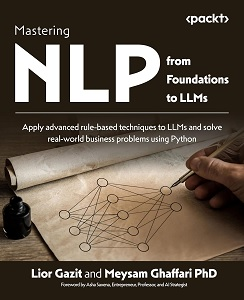

colab 실습 : 
https://github.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/Mastering-NLP-from-Foundations-to-LLMs/blob/main/Chapter9_notebooks/Ch9_RAGLlamaIndex_Prompt_Compression.ipynb)  


Colab notebook:
https://github.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs   
<a target="_blank" href="https://colab.research.google.com/github/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/blob/liors_branch/Chapter9_notebooks/Ch9_RAGLlamaIndex_Prompt_Compression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**노트북의 목적:**
이 노트북은 RAG의 검색 문맥에 콘텐츠 압축을 적용했을 때의 영향을 연구하기 위해 설계되었습니다.

일반적으로 RAG 방식을 사용할 때, 프롬프트에서 가장 많은 토큰은 LLM이 작업 수행 시 참조할 수 있도록 데이터베이스에서 RAG가 검색한 문맥에서 발생합니다.

우리는 정보 밀도가 낮은 긴 문맥을 압축해 효율성을 높이는 것을 목표로 하는 [**LongLLMLingua**](https://arxiv.org/abs/2310.06839)를 사용하여 프롬프트 압축을 검토합니다. 이를 통해 질문에 필요한 모든 관련 정보는 유지하면서 전송되는 토큰 수를 줄이는 효과를 기대할 수 있습니다.

압축 과정은 사용자의 프롬프트를 기반으로 진행되며, 무료 로컬 LLM인 Llama2에서 이루어져 추가 API 비용이 발생하지 않습니다.

**실험 설명:**
각 실험은 사용자가 특정 Arxiv 출판물에 대해 질문하기 위해 RAG 작업을 설정하는 것을 나타냅니다.

실험마다 무작위로 선택된 AI 관련 Arxiv 출판물을 대상으로 사용자가 해당 출판물이 강화학습 주제를 다루는지 묻습니다. 이는 출판물 내용을 기반으로 한 이진 분류 요청에 해당하며, 이 작업을 위해 OpenAI의 GPT 모델을 사용합니다.

각 출판물이 허용된 프롬프트 길이를 초과할 정도로 길기 때문에, RAG가 적용되어 출판물 내용을 청크로 나누어 벡터 데이터베이스에 저장합니다.

각 실험에서 두 가지 접근 방식이 사용됩니다:
1. 검색된 문맥을 사용자의 질문에 첨부하여 OpenAI의 GPT로 전송해 분류합니다.
2. 검색된 문맥을 **LongLLMLingua로 압축**한 후 질문에 첨부하여 OpenAI의 GPT로 전송해 분류합니다.

각 접근 방식에 대해 다음 지표를 측정합니다:
* OpenAI의 GPT로 전송된 토큰 수
* 처리 시간
* 두 접근 방식 간 분류 결과의 일치/불일치

**결과:**
이 노트북은 LongLLMLingua 사용의 트레이드오프를 요약하며 연구 결과를 제공합니다.

분석을 완료하기 위해서는 노트북 **Ch9_Completing_a_Complex_Analysis_with_a_Team_of_LLM_Agents.ipynb**의 LLM 에이전트 팀 활용을 참조하세요.

**요구 사항:**
* Colab에서 실행할 경우, 다음 런타임 설정을 사용하세요: `Python3, T4 GPU`
* OpenAI API 사용을 위해 유료 **API 키**가 필요합니다.

>*```면책사항: 이 노트북에서 다루는 내용과 아이디어는 저자들 개인의 것이며, 저자들의 고용주의 견해나 지적 재산을 대변하지 않습니다.```*

설치 :

In [ ]:
# 참고사항:
# 아래 코드가 Python 패키지 의존성 문제로 오류가 발생하면, 이는 새로운 버전의 영향일 수 있습니다.
# 이럴 때 default_installations를 False로 설정하여 원저자가 설정한 의존성을 따르게 할 수 있습니다.
default_installations = True
if default_installations:
    !pip install -q llmlingua llama-index==0.10.7 accelerate datasets llama-index-postprocessor-longllmlingua
else:
    import requests
    text_file_path = "requirements__Ch9_RAGLlamaIndex_Prompt_Compression.txt"
    url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/" + text_file_path
    res = requests.get(url)
    with open(text_file_path, "w") as f:
        f.write(res.text)

    !pip install -r requirements__Ch9_RAGLlamaIndex_Prompt_Compression.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==

Import:

In [ ]:
import torch
import gc
import openai
from datasets import load_dataset
import pandas as pd
from llama_index.core import Document
from llama_index.core import VectorStoreIndex
from llama_index.llms.openai import OpenAI
from llama_index.core.indices.query.schema import QueryBundle
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.postprocessor.longllmlingua import LongLLMLinguaPostprocessor
import random
import time
import pickle
import os

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### 설정

In [ ]:
# 비압축 RAG에서 사용할 프롬프트 모델 유형을 설정합니다.
# (압축 RAG의 프롬프트 모델은 기본값으로 "gpt-4o-mini"로 설정되어 있으며,
# 압축 모델은 기본값으로 "NousResearch/Llama-2-7b-hf"로 설정됩니다.)
gpt_type = "gpt-4o-mini"

# 실행할 실험 횟수입니다. 각 실험은 사용자가 특정 Arxiv 출판물에 대해 질문을 하는 RAG 작업을 나타냅니다.
num_of_iterations = 60

# 각 실험에서 Arxiv 출판물은 랜덤하게 선택되므로, 원래 결과의 재현성을 보장하기 위해 고정된 시드를 설정합니다.
set_seed = 0

# 각 실험에서 RAG가 검색할 유사한 청크의 개수입니다.
similarity_top_k = 5

# 검색된 문맥을 압축할 때 목표로 하는 토큰 수입니다.
target_token = 2**9

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

OpenAI API key:  
**문자열 형태로 아래 "..."에 OpenAI에서 발급받은 key를 입력해 주세요!**  


Colab 보안 비밀 설정은 왼쪽 열쇠 모양의 아이콘을 클릭하면 나옵니다.
<img src="https://i.imgur.com/7P383n4.png" width="500">

유료 LLM이 아닌 무료 LLM을 활용하고자 한다면, 책에서 설명하는 허깅페이스를 활용하는 예제를 따라 대체 방법을 사용해 보세요.

In [ ]:
openai.api_key = "..."

In [ ]:
# Colab 에서는 보안 비밀키 설정을 통해 API 키를 매번 입력하지 않고 아랴와 같이 관리할 수 있습니다.
try:
    from google.colab import userdata
    openai.api_key = userdata.get('OPENAI_API_KEY')
    if not openai.api_key:
        raise ValueError("Colab의 보안 비밀 설정에서 'OPENAI_API_KEY'를 찾을 수 없습니다.")
except ImportError:
    print("Colab 환경이 아니므로, 'api_key' 변수에 직접 값을 할당해야 합니다.")

## 데이터 수집
데이터 출처:  
https://huggingface.co/datasets/ccdv/arxiv-classification
  
여기에는 전체 [Arxiv](https://arxiv.org/) 출판물의 내용이 포함되어 있습니다.
인공지능 카테고리를 중심으로 다룰 예정입니다.

In [ ]:
dataset = load_dataset("ccdv/arxiv-classification")
dataset_train = dataset["train"]
dataset_train_df = pd.DataFrame(dataset_train)

# AI 관련 논문만 유지 (라벨이 #2로 분류된 것만 필터링):
dataset_train_df_ai = dataset_train_df[dataset_train_df["label"] == 2].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.4M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28388 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

출판된 논문 중 하나의 전체 내용을 살펴보겠습니다:

In [ ]:
dataset_train_df_ai.head(1).style.set_properties(**{'text-align': 'left'})

llama_index의 문서 유형을 리스트로 정의합니다.

In [ ]:
articles = [Document(text=content) for content in dataset_train_df_ai["text"]]

In [ ]:
print("'articles'는 리스트이며, 각 요소는 다음과 같은 유형입니다.:", type(articles[0]))

'articles'는 리스트이며, 각 요소는 다음과 같은 유형입니다.: <class 'llama_index.core.schema.Document'>


## 대규모 언어 모델 설정
OpenAI API 를 통한 대규모 언어 모델 설정과 LongLLMLinguaPostprocessor

In [ ]:
# OpenAI의 LLM 초기화
llm = OpenAI(model=gpt_type)

# LongLLMLinguaPostprocessor 초기화
postprocessor = LongLLMLinguaPostprocessor(
    model_name="NousResearch/Llama-2-7b-hf",  # 후처리 작업에 사용할 모델 이름 설정
    # model_name = "beomi/open-llama-2-ko-7b", # 한국어를 지원하는 모델로 변경 가능
    target_token=target_token,  # 후처리에서 목표로 하는 특정 토큰 설정
    rank_method="longllmlingua",  # 긴 문서에서 중요 정보를 랭킹하는 방법 설정
    additional_compress_kwargs={  # 추가적인 후처리 매개변수 설정
        "condition_compare": True,  # 컨텍스트를 조건과 비교하여 중요 정보 선별
        "condition_in_question": "after",  # 질문 이후의 정보를 선호하여 처리
        "context_budget": "+100",  # 컨텍스트 길이를 추가로 확보 (100 토큰 추가)
        "reorder_context": "sort",  # 컨텍스트를 재정렬하여 중요한 정보를 상위로 이동
        "dynamic_context_compression_ratio": 0.3,  # 컨텍스트를 30%로 압축
    },
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

## 실험
각 실험은 서로 독립적으로 진행됩니다.
각 실험에서 대규모 언어 모델은 특정 논문이 강화 학습 주제를 다루고 있는지 여부를 분류하는 개별 RAG 작업을 수행합니다.
이 작업은 두 가지 방식으로 이루어지며, 하나는 일반적인 RAG 접근 방식이고, 다른 하나는 LongLLMLingua RAG 접근 방식입니다. 후자의 경우, 검색된 문맥을 LLM에 참조로 전달하기 전에 압축합니다.

In [ ]:
query = "Does this publication involve Reinforcement Learning? Answer in a single word, either Yes or No"
# query = "이 출판물이 강화 학습(Reinforcement Learning)과 관련이 있나요? 단어 하나로 대답하세요, Yes 또는 No 중 하나로."

# 결과를 기록할 딕셔너리 설정:
# 두 가지 분류 RAG 간의 일치 여부와 추적 중인 메트릭을 저장:
record = {
    "Yes,Yes": 0,  # 두 방식 모두 긍정
    "No,No": 0,    # 두 방식 모두 부정
    "Yes,No": 0,   # 비압축 방식 긍정, 압축 방식 부정
    "No,Yes": 0,   # 비압축 방식 부정, 압축 방식 긍정
    "original_tokens": [],  # 원래 문맥의 토큰 수
    "compressed_tokens": [],  # 압축된 문맥의 토큰 수
    "ratios": [],  # 압축 비율
    "time_nc": [],  # 비압축 방식의 실행 시간
    "time_c": [],   # 압축 방식의 실행 시간
}

# GPU의 불필요한 캐시 공간을 정리하는 것은 좋은 습관입니다:
gc.collect()
torch.cuda.empty_cache()

# 모든 문서를 반복하지 않기 위해 랜덤하게 문서를 선택합니다:
random.seed(set_seed)
random_iterations = random.sample(range(len(articles)), num_of_iterations)
iteration_counter = 1

# 이제 각 문서에 대해 독립적인 실험을 진행하며 반복합니다:
for document_index in random_iterations:
    # 검색을 위해 관련 문서만 참조하고 이를 벡터 데이터베이스로 처리:
    index = VectorStoreIndex.from_documents(articles[document_index:(document_index + 1)])
    print("\n\n                                                 문서 인덱스:", document_index)
    print("                                                 반복 횟수:", iteration_counter, "/", num_of_iterations)
    iteration_counter += 1

    # RAG 검색: 이 부분은 비압축 및 압축 방식 모두에서 공통:
    retrieval_start_time = time.time()
    # 벡터 DB에서 top_k 청크 검색:
    retriever = index.as_retriever(similarity_top_k=similarity_top_k)
    retrieved_context = retriever.retrieve(query)
    context_list = [chunk.get_content() for chunk in retrieved_context]
    retrieval_time = time.time() - retrieval_start_time

    # 비압축 RAG 방식:
    # 압축 없이 LLM에 프롬프트를 전달하며, 쿼리에 검색된 문맥 청크를 추가:
    start_time_nc = time.time()
    prompt = "\n\n".join(context_list + [query])
    response_nc = llm.complete(prompt)
    time_nc = time.time() - start_time_nc
    print("------------------------------------------------ 비압축 방식 응답: " + str(response_nc))

    original_contexts = "\n\n".join(context_list)
    original_tokens = postprocessor._llm_lingua.get_token_length(original_contexts)

    # 이 시점에서 GPU 메모리를 정리하는 것이 필요합니다:
    del prompt
    del context_list
    del original_contexts
    gc.collect()
    torch.cuda.empty_cache()

    # 압축 문맥 RAG 방식:
    # 압축된 문맥으로 LLM에 프롬프트 전달:
    start_time_c = time.time()
    new_retrieved_context = postprocessor.postprocess_nodes(
        retrieved_context,
        query_bundle=QueryBundle(query_str=query)
    )

    response_c = CompactAndRefine().synthesize(query, new_retrieved_context)

    time_c = time.time() - start_time_c

    print("------------------------------------------------ 압축 방식 응답: " + str(response_c))

    compressed_contexts = "\n\n".join([chunk.get_content() for chunk in new_retrieved_context])

    compressed_tokens = postprocessor._llm_lingua.get_token_length(compressed_contexts)
    ratio = original_tokens / (compressed_tokens + 1)

    print("원래 토큰 수:", original_tokens)
    print("압축된 토큰 수:", compressed_tokens)
    print("압축 비율:", f"{ratio:.2f}배")

    record[str(response_nc).replace(".", "") + "," + str(response_c).replace(".", "")] += 1
    record["original_tokens"].append(original_tokens)
    record["compressed_tokens"].append(compressed_tokens)
    record["ratios"].append(ratio)
    record["time_nc"].append(time_nc + retrieval_time)
    record["time_c"].append(time_c + retrieval_time)

    # GPU의 불필요한 캐시 공간을 정리하는 것은 좋은 습관입니다:
    del compressed_contexts
    del new_retrieved_context
    del retrieved_context
    gc.collect()
    torch.cuda.empty_cache()



                                                 문서 인덱스: 1577
                                                 반복 횟수: 1 / 60
------------------------------------------------ 비압축 방식 응답: Yes
------------------------------------------------ 압축 방식 응답: Yes
원래 토큰 수: 5121
압축된 토큰 수: 357
압축 비율: 14.30배


                                                 문서 인덱스: 1722
                                                 반복 횟수: 2 / 60
------------------------------------------------ 비압축 방식 응답: No
------------------------------------------------ 압축 방식 응답: No
원래 토큰 수: 5565
압축된 토큰 수: 437
압축 비율: 12.71배


                                                 문서 인덱스: 165
                                                 반복 횟수: 3 / 60
------------------------------------------------ 비압축 방식 응답: No
------------------------------------------------ 압축 방식 응답: Yes
원래 토큰 수: 5595
압축된 토큰 수: 428
압축 비율: 13.04배


                                                 문서 인덱스: 1060
                                                 반복 

# 문맥 데이터 압축의 양면성: 시스템 자원 최적화와 분류 성능 손실

### 분류 성능
검색된 컨텍스트 압축의 영향을 측정합니다.
다른 모든 요소를 일정하게 유지하면서, 즉 동일한 프롬프트와 동일한 대규모 언어 모델 선택에 대해, 원본 형태의 컨텍스트를 활용한 경우와 이를 압축했을 때의 일치율을 확인합니다.

In [ ]:
num_of_iterations_in_practice = len(record["original_tokens"])
counts_of_agreements = record["Yes,Yes"] + record["No,No"]
counts_of_disagreements = record["Yes,No"] + record["No,Yes"]
reduction_in_tokens = round(100*(1 - sum(record["compressed_tokens"]) / sum(record["original_tokens"])))

In [ ]:
print("일치 횟수:", str(counts_of_agreements), "전체 사례", str(num_of_iterations_in_practice), "중")
print("불일치 횟수:", str(counts_of_disagreements), "전체 사례", str(num_of_iterations_in_practice), "중")
print(f"일치율: {round(100*counts_of_agreements / num_of_iterations_in_practice)}%")

일치 횟수: 56 전체 사례 60 중
불일치 횟수: 4 전체 사례 60 중
일치율: 93%


### 전송 토큰의 감소는 곧바로 비용 절감으로 이어짐
주목할 점은 우리의 활용 사례에서 반환되는 응답이 단일 단어, 즉 단일 토큰이라는 것입니다. 따라서 두 RAG 케이스 모두에서 동일하게 유지되는 반환 토큰의 감소를 평가할 필요가 없습니다.

In [ ]:
print(f"비압축 방식: {num_of_iterations_in_practice}번 호출에서 전송된 총 토큰 수:", str(sum(record["original_tokens"])))
print(f"압축 방식:   {num_of_iterations_in_practice}번 호출에서 전송된 총 토큰 수:", str(sum(record["compressed_tokens"])))
print(f"토큰 감소율: {reduction_in_tokens}%")
print("압축 비율:", f"{1 / (1 - reduction_in_tokens/100):.2f}배")

비압축 방식: 60번 호출에서 전송된 총 토큰 수: 327688
압축 방식:   60번 호출에서 전송된 총 토큰 수: 26743
토큰 감소율: 92%
압축 비율: 12.50배


## 처리 소요 시간

In [ ]:
print(f"비압축 방식: {num_of_iterations_in_practice}번 호출 동안의 총 반복 시간:", str(round(sum(record["time_nc"]))))
print(f"압축 방식:   {num_of_iterations_in_practice}번 호출 동안의 총 반복 시간:", str(round(sum(record["time_c"]))))

비압축 방식: 60번 호출 동안의 총 반복 시간: 57
압축 방식:   60번 호출 동안의 총 반복 시간: 640


## **결론**
설정된 환경, 하이퍼파라미터, 임베딩, 대규모 언어 모델에서의 결론

In [ ]:
reduction_in_agreement = round(100*(record["Yes,No"] + record["No,Yes"]) / num_of_iterations_in_practice)
print(f"분류 일치율이 {reduction_in_agreement}% 감소하는 동안, 토큰 감소로 인한 비용 절감율은 {reduction_in_tokens}%입니다.\n")
print(f"즉, 압축 전 $100의 비용이 압축 후에는 {100 - reduction_in_tokens}$로 줄어듭니다.")
print("*두 접근 방식 간의 불일치는 어느 한쪽이 올바른 결과일 수 있음을 의미하며, 압축되지 않은 방식이 더 신뢰할 수 있다고 가정해서는 안 됩니다. 압축되지 않은 방식 또한 희소할 수 있기 때문입니다.")
print("**압축기 사용에는 GPU가 필요한 로컬 LLM 활용과 같은 다른 절충이 따른다는 점을 기억하세요.")

분류 일치율이 7% 감소하는 동안, 토큰 감소로 인한 비용 절감율은 92%입니다.

즉, 압축 전 $100의 비용이 압축 후에는 8$로 줄어듭니다.
*두 접근 방식 간의 불일치는 어느 한쪽이 올바른 결과일 수 있음을 의미하며, 압축되지 않은 방식이 더 신뢰할 수 있다고 가정해서는 안 됩니다. 압축되지 않은 방식 또한 희소할 수 있기 때문입니다.
**압축기 사용에는 GPU가 필요한 로컬 LLM 활용과 같은 다른 절충이 따른다는 점을 기억하세요.


In [ ]:
out = open("record.pickle", "wb")
pickle.dump(record, out)
out.close()

이 노트북을 Google Colab에서 실행한다면, 다음 명령어를 통해 `record` 딕셔너리가 여러분의 다운로드 폴더로 다운로드됩니다.

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import files
    files.download("record.pickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>